<a href="https://colab.research.google.com/github/bananighosh/Fall-2023-NYU-AI/blob/main/finals/bg2502_take_at_home_conditional_variational_autoencoder_and_t_sne.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## PROBLEM SET 1 - TAKE AT HOME (25 POINTS)

**You will lose all corresponding points if we can't access the implementation notebook URL or the Github URL. We will NOT message you. Do NOT invite the TAs to your Github repo (option 2 below) EARLIER than the morning of the day of the exam, since invites expire in 7 days.**

## Introduction

In the last few years, the field of generative modeling has seen a lot of progress. The techniques that have been developed in this field are very useful for other tasks such as semi-supervised learning, representation learning, and reinforcement learning. In this problem statement we attempt to prepare you to understand the basics of a technique that has been very successful in generative modeling: Variational Autoencoders (VAEs). Understanding VAEs is  the key for you to get a head start with more advanced models such as [Stable Diffusion that are all the rage these days](https://clipdrop.co/stable-diffusion-turbo).



## Task 1: Study what VAEs are and how they work (0 points)

Consult this [blog post](https://jaan.io/what-is-variational-autoencoder-vae-tutorial/) and its [2D VAE autoencoder implemenation for the MNIST dataset](https://github.com/jaanli/variational-autoencoder).

## Task 2: Replicate the VAE for the MNIST dataset (25 points)

Implement the VAE model for the MNIST dataset and train it ensuring that you plot the loss curves for the training and validation sets and perform hyperparameter optimization on the size of the latent space as well as on the optimizer parameters. To all points you need to include as comments in the code or as markdown cells what each function in the code is doing. Don't be frugal in your commentary. (15 points)

Replicate the figure showing the final latent variable space shown below. Note that you will not produce the animated figure shown below but show only the final latent space $(z_1, z_2)$. (5 points)

Show VAE generated images for all digits 0-9 after model training. (5 points)

![](latent-variables.gif)

# Fun with Conditional Variational Autoencoders

This is a starter kernel to understand the main principles of conditional variational autoencoders. PyTorch will be used for modelling.


In this kernel we will discuss the conditional variation of the autoencoder and build a model, train it and analyse the latent space with t-SNE technique.

![architecture](https://www.mdpi.com/sensors/sensors-19-02528/article_deploy/html/images/sensors-19-02528-g002.png)


# MNIST dataset

We will use the MNIST dataset because it's simple and small. You can fork this notebook and experiment with the dataset you like. Fashion MNIST, etc.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox, TextArea
import matplotlib
import numpy as np
import pandas as pd
import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils import data
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image
from sklearn.model_selection import train_test_split
from tqdm import tqdm, tqdm_notebook
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('Training on',DEVICE)

Training on cuda


In [2]:
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
batch_size = 128
learning_rate = 0.005
input_size = 28*28
hidden_size = 12
labels_length = 10

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [5]:
dataset = MNIST('./data', transform=transform, download=True)
train_data, test_data = data.random_split(dataset, (50000,10000))

train_dataset = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_dataset = DataLoader(test_data, batch_size=batch_size, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 269886278.03it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 52690601.92it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 87691671.91it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




100%|██████████| 4542/4542 [00:00<00:00, 19399723.80it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [6]:
#helper functions
def one_hot(x, max_x):
    return torch.eye(max_x + 1)[x]

def plot_gallery(images, h, w, n_row=3, n_col=6):
    plt.figure(figsize=(2 * n_col, 2 * n_row))
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.axis("off")
        plt.imshow(images[i].reshape(h, w), cmap = matplotlib.cm.binary)
    plt.show()

def plot_loss(history):
    loss, val_loss = zip(*history)
    plt.figure(figsize=(15, 9))
    plt.plot(loss, label="train_loss")
    plt.plot(val_loss, label="val_loss")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.show()

In [7]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_size + labels_length, 64),
            #nn.ReLU(True),
            #nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Linear(64, hidden_size))

        self.decoder = nn.Sequential(
            nn.Linear(hidden_size + labels_length, 64),
            nn.ReLU(True),
            #nn.Linear(64, 128),
            #nn.ReLU(True),
            nn.Linear(64, input_size),
            nn.Tanh())

    def encode(self, x, labels):
        x = x.view(-1, 1*28*28)
        x = torch.cat((x,labels),dim=1)
        return self.encoder(x)

    def decode(self, x, labels):
        x = torch.cat((x,labels),dim=1)
        return self.decoder(x)

    def forward(self, x, labels):
        x = self.encode(x,labels)
        x = self.decode(x,labels)
        return x

In [8]:
model = autoencoder().to(DEVICE)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [9]:
def fit_epoch(model, train_loader, criterion, optimizer, is_cvae):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = one_hot(labels,9).to(DEVICE)
        optimizer.zero_grad()
        if is_cvae:
            outputs, mu, logvar = model(inputs,labels)
            loss = vae_loss_fn(inputs.view(-1,28*28), outputs, mu, logvar)
            loss.backward()
        else:
            outputs = model(inputs,labels)
            loss = criterion(outputs, inputs.view(-1,28*28))
            loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    return train_loss

def eval_epoch(model, val_loader, criterion, is_cvae):
    model.eval()
    running_loss = 0.0
    processed_size = 0
    inp,out = [],[]
    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = one_hot(labels,9).to(DEVICE)

        with torch.set_grad_enabled(False):
            if is_cvae:
                outputs, mu, logvar = model(inputs,labels)
                loss = vae_loss_fn(inputs.view(-1,28*28), outputs, mu, logvar)
                loss.backward()
            else:
                outputs = model(inputs,labels)
                loss = criterion(outputs, inputs.view(-1,28*28))
                inp,out = inputs, outputs

        running_loss += loss.item() * inputs.size(0)
        processed_size += inputs.size(0)

    with torch.set_grad_enabled(False):
        plot_gallery([inp[0].cpu(),out[0].cpu()],28,28,1,2)

    val_loss = running_loss / processed_size
    return val_loss

def train(train_loader, val_loader, model, epochs, batch_size, is_cvae=False):
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} val_loss {v_loss:0.4f}"
    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        criterion = nn.MSELoss()
        for epoch in range(epochs):
            train_loss = fit_epoch(model, train_loader, criterion, opt, is_cvae)
            print("loss", train_loss)
            val_loss = eval_epoch(model, val_loader, criterion, is_cvae)
            history.append((train_loss, val_loss))
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss, v_loss=val_loss))
    return history

epoch:   0%|          | 0/200 [00:00<?, ?it/s]

loss 0.19220791301727294


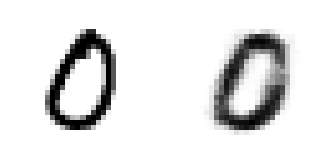

epoch:   0%|          | 1/200 [00:14<46:36, 14.05s/it]


Epoch 001 train_loss: 0.1922 val_loss 0.1186
loss 0.10932358447790146


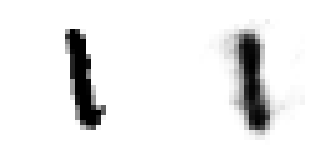

epoch:   1%|          | 2/200 [00:27<44:51, 13.59s/it]


Epoch 002 train_loss: 0.1093 val_loss 0.1036
loss 0.09933730734109879


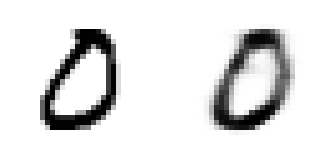

epoch:   2%|▏         | 3/200 [00:40<44:06, 13.44s/it]


Epoch 003 train_loss: 0.0993 val_loss 0.0968
loss 0.09444289555072785


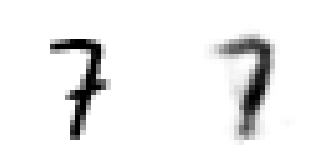

epoch:   2%|▏         | 4/200 [00:54<43:59, 13.47s/it]


Epoch 004 train_loss: 0.0944 val_loss 0.0929
loss 0.0910035407614708


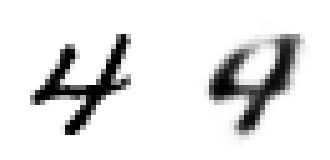

epoch:   2%|▎         | 5/200 [01:07<43:29, 13.38s/it]


Epoch 005 train_loss: 0.0910 val_loss 0.0905
loss 0.08865583180189132


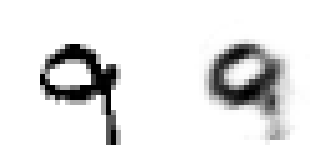

epoch:   3%|▎         | 6/200 [01:22<45:13, 13.99s/it]


Epoch 006 train_loss: 0.0887 val_loss 0.0881
loss 0.08680188101530074


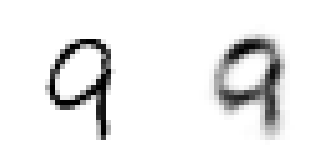

epoch:   4%|▎         | 7/200 [01:35<44:27, 13.82s/it]


Epoch 007 train_loss: 0.0868 val_loss 0.0864
loss 0.08497405550479889


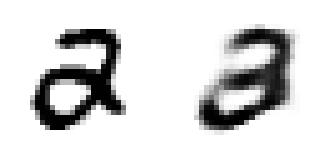

epoch:   4%|▍         | 8/200 [01:49<43:44, 13.67s/it]


Epoch 008 train_loss: 0.0850 val_loss 0.0848
loss 0.08344561459302902


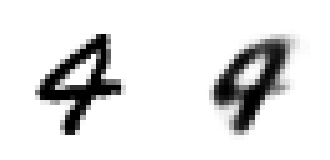

epoch:   4%|▍         | 9/200 [02:02<42:50, 13.46s/it]


Epoch 009 train_loss: 0.0834 val_loss 0.0834
loss 0.08209041586637497


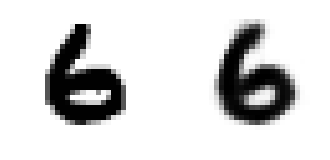

epoch:   5%|▌         | 10/200 [02:15<41:59, 13.26s/it]


Epoch 010 train_loss: 0.0821 val_loss 0.0820
loss 0.08078580491781234


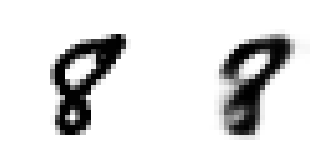

epoch:   6%|▌         | 11/200 [02:28<41:36, 13.21s/it]


Epoch 011 train_loss: 0.0808 val_loss 0.0809
loss 0.07966831510782242


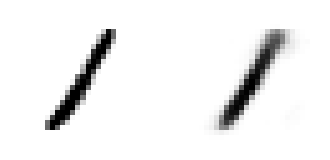

epoch:   6%|▌         | 12/200 [02:41<41:15, 13.17s/it]


Epoch 012 train_loss: 0.0797 val_loss 0.0796
loss 0.0785858093881607


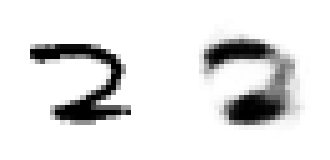

epoch:   6%|▋         | 13/200 [02:54<41:08, 13.20s/it]


Epoch 013 train_loss: 0.0786 val_loss 0.0790
loss 0.0776389627289772


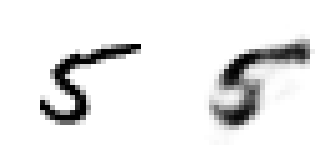

epoch:   7%|▋         | 14/200 [03:07<40:49, 13.17s/it]


Epoch 014 train_loss: 0.0776 val_loss 0.0780
loss 0.07676917119026185


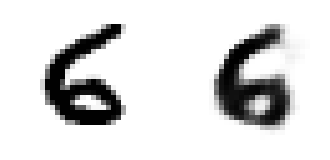

epoch:   8%|▊         | 15/200 [03:20<40:25, 13.11s/it]


Epoch 015 train_loss: 0.0768 val_loss 0.0769
loss 0.0759831759262085


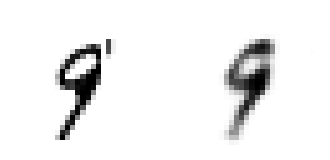

epoch:   8%|▊         | 16/200 [03:33<40:07, 13.08s/it]


Epoch 016 train_loss: 0.0760 val_loss 0.0763
loss 0.07528037713289261


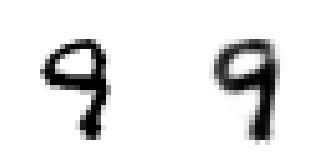

epoch:   8%|▊         | 17/200 [03:47<40:18, 13.22s/it]


Epoch 017 train_loss: 0.0753 val_loss 0.0757
loss 0.07461600008249283


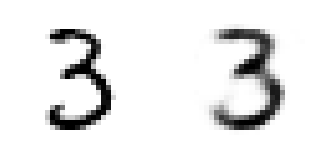

epoch:   9%|▉         | 18/200 [04:00<40:01, 13.20s/it]


Epoch 018 train_loss: 0.0746 val_loss 0.0750
loss 0.07397644977807999


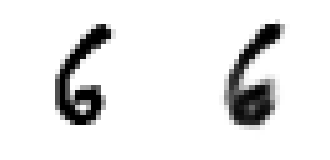

epoch:  10%|▉         | 19/200 [04:13<39:49, 13.20s/it]


Epoch 019 train_loss: 0.0740 val_loss 0.0748
loss 0.07339473616123199


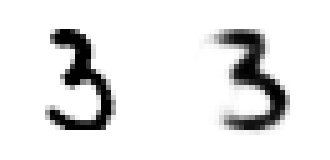

epoch:  10%|█         | 20/200 [04:27<40:00, 13.34s/it]


Epoch 020 train_loss: 0.0734 val_loss 0.0740
loss 0.07282076656103134


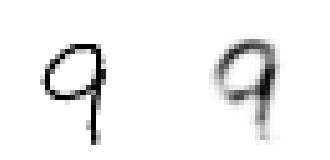

epoch:  10%|█         | 21/200 [04:40<39:47, 13.34s/it]


Epoch 021 train_loss: 0.0728 val_loss 0.0734
loss 0.07237538276910782


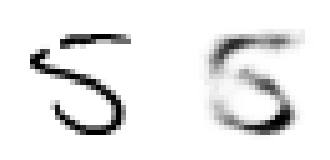

epoch:  11%|█         | 22/200 [04:55<40:38, 13.70s/it]


Epoch 022 train_loss: 0.0724 val_loss 0.0730
loss 0.07186149152994156


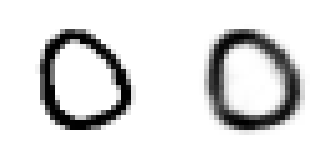

epoch:  12%|█▏        | 23/200 [05:08<39:52, 13.51s/it]


Epoch 023 train_loss: 0.0719 val_loss 0.0724
loss 0.07148975556135177


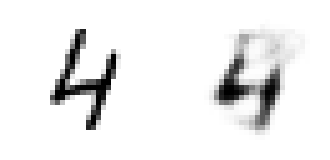

epoch:  12%|█▏        | 24/200 [05:21<39:14, 13.38s/it]


Epoch 024 train_loss: 0.0715 val_loss 0.0722
loss 0.07110967711925506


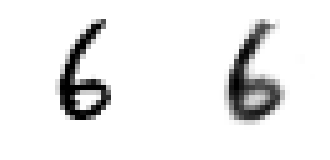

epoch:  12%|█▎        | 25/200 [05:34<38:49, 13.31s/it]


Epoch 025 train_loss: 0.0711 val_loss 0.0716
loss 0.07070723833799362


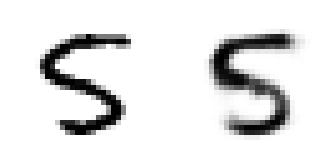

epoch:  13%|█▎        | 26/200 [05:47<38:31, 13.29s/it]


Epoch 026 train_loss: 0.0707 val_loss 0.0715
loss 0.07033665196657181


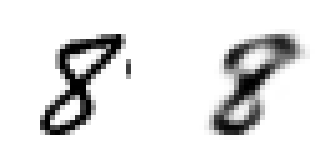

epoch:  14%|█▎        | 27/200 [06:00<38:15, 13.27s/it]


Epoch 027 train_loss: 0.0703 val_loss 0.0710
loss 0.07005070630550385


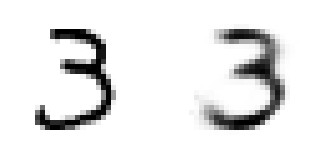

epoch:  14%|█▍        | 28/200 [06:13<37:50, 13.20s/it]


Epoch 028 train_loss: 0.0701 val_loss 0.0707
loss 0.06969606330633163


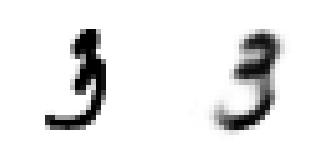

epoch:  14%|█▍        | 29/200 [06:27<37:37, 13.20s/it]


Epoch 029 train_loss: 0.0697 val_loss 0.0703
loss 0.06941252099514007


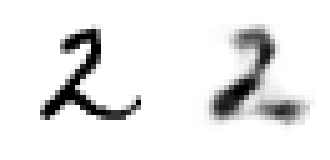

epoch:  15%|█▌        | 30/200 [06:40<37:37, 13.28s/it]


Epoch 030 train_loss: 0.0694 val_loss 0.0705
loss 0.06910032568454742


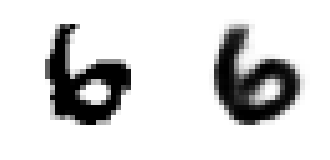

epoch:  16%|█▌        | 31/200 [06:53<37:22, 13.27s/it]


Epoch 031 train_loss: 0.0691 val_loss 0.0700
loss 0.06887664809703826


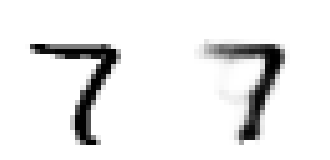

epoch:  16%|█▌        | 32/200 [07:06<37:02, 13.23s/it]


Epoch 032 train_loss: 0.0689 val_loss 0.0697
loss 0.0686194492650032


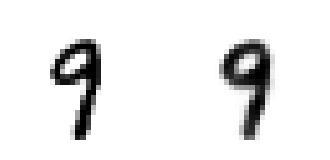

epoch:  16%|█▋        | 33/200 [07:20<36:51, 13.24s/it]


Epoch 033 train_loss: 0.0686 val_loss 0.0697
loss 0.06837701002120972


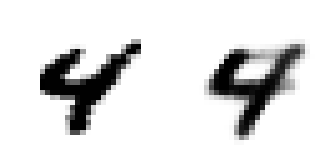

epoch:  17%|█▋        | 34/200 [07:33<36:33, 13.22s/it]


Epoch 034 train_loss: 0.0684 val_loss 0.0689
loss 0.0680733581662178


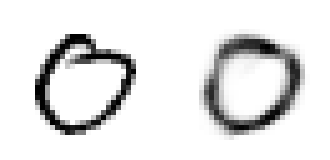

epoch:  18%|█▊        | 35/200 [07:46<36:16, 13.19s/it]


Epoch 035 train_loss: 0.0681 val_loss 0.0689
loss 0.06781439123868942


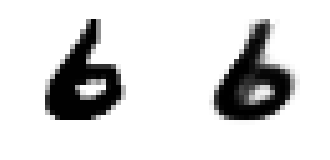

epoch:  18%|█▊        | 36/200 [08:00<36:19, 13.29s/it]


Epoch 036 train_loss: 0.0678 val_loss 0.0686
loss 0.06758823921442032


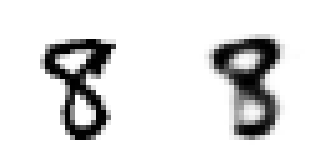

epoch:  18%|█▊        | 37/200 [08:13<36:10, 13.31s/it]


Epoch 037 train_loss: 0.0676 val_loss 0.0685
loss 0.06734629124641418


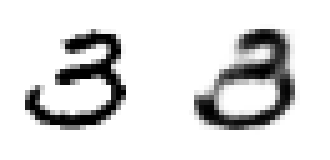

epoch:  19%|█▉        | 38/200 [08:26<35:56, 13.31s/it]


Epoch 038 train_loss: 0.0673 val_loss 0.0681
loss 0.06716755675315857


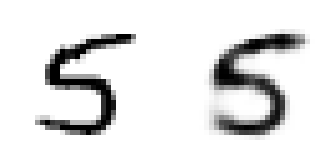

epoch:  20%|█▉        | 39/200 [08:39<35:41, 13.30s/it]


Epoch 039 train_loss: 0.0672 val_loss 0.0680
loss 0.06690804353237152


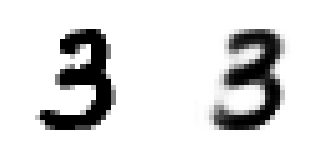

epoch:  20%|██        | 40/200 [08:53<35:32, 13.33s/it]


Epoch 040 train_loss: 0.0669 val_loss 0.0677
loss 0.06673688627004623


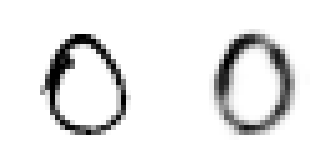

epoch:  20%|██        | 41/200 [09:06<35:10, 13.28s/it]


Epoch 041 train_loss: 0.0667 val_loss 0.0675
loss 0.06653967808127403


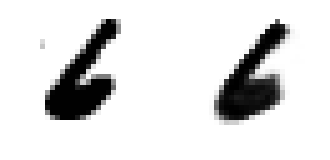

epoch:  21%|██        | 42/200 [09:19<35:05, 13.33s/it]


Epoch 042 train_loss: 0.0665 val_loss 0.0677
loss 0.06636139683485032


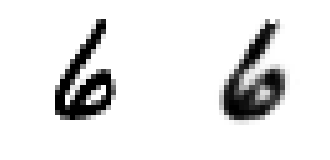

epoch:  22%|██▏       | 43/200 [09:33<35:06, 13.42s/it]


Epoch 043 train_loss: 0.0664 val_loss 0.0672
loss 0.0662102043890953


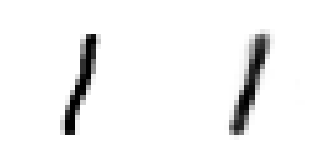

epoch:  22%|██▏       | 44/200 [09:46<34:38, 13.33s/it]


Epoch 044 train_loss: 0.0662 val_loss 0.0671
loss 0.0660981607222557


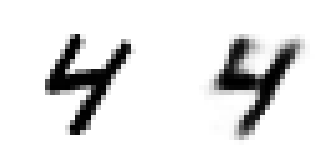

epoch:  22%|██▎       | 45/200 [09:59<34:14, 13.26s/it]


Epoch 045 train_loss: 0.0661 val_loss 0.0670
loss 0.0659497537779808


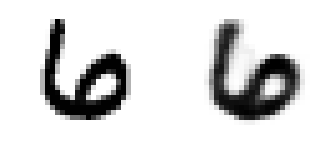

epoch:  23%|██▎       | 46/200 [10:12<33:56, 13.23s/it]


Epoch 046 train_loss: 0.0659 val_loss 0.0667
loss 0.06575589988470078


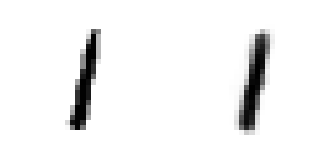

epoch:  24%|██▎       | 47/200 [10:26<33:43, 13.22s/it]


Epoch 047 train_loss: 0.0658 val_loss 0.0667
loss 0.0656064822435379


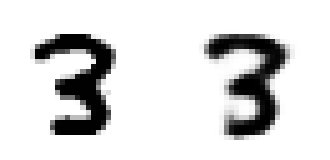

epoch:  24%|██▍       | 48/200 [10:39<33:23, 13.18s/it]


Epoch 048 train_loss: 0.0656 val_loss 0.0666
loss 0.06550013754129409


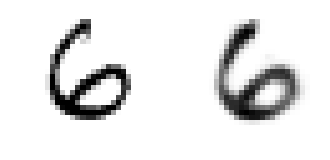

epoch:  24%|██▍       | 49/200 [10:52<33:17, 13.23s/it]


Epoch 049 train_loss: 0.0655 val_loss 0.0664
loss 0.06538376302957535


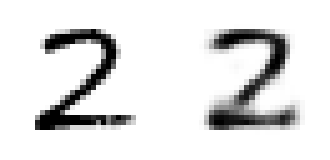

epoch:  25%|██▌       | 50/200 [11:05<33:11, 13.28s/it]


Epoch 050 train_loss: 0.0654 val_loss 0.0663
loss 0.06526766731739045


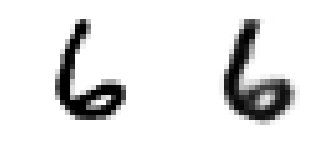

epoch:  26%|██▌       | 51/200 [11:19<32:54, 13.25s/it]


Epoch 051 train_loss: 0.0653 val_loss 0.0663
loss 0.06506313961982726


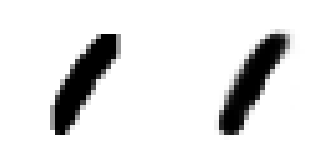

epoch:  26%|██▌       | 52/200 [11:32<32:42, 13.26s/it]


Epoch 052 train_loss: 0.0651 val_loss 0.0660
loss 0.06490111963272095


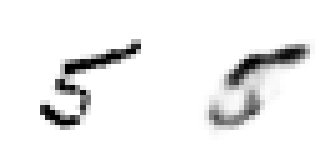

epoch:  26%|██▋       | 53/200 [11:45<32:29, 13.26s/it]


Epoch 053 train_loss: 0.0649 val_loss 0.0659
loss 0.06483702823638916


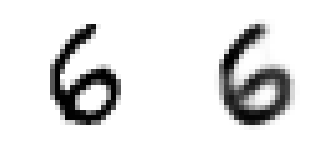

epoch:  27%|██▋       | 54/200 [11:58<32:13, 13.24s/it]


Epoch 054 train_loss: 0.0648 val_loss 0.0656
loss 0.06473565032482147


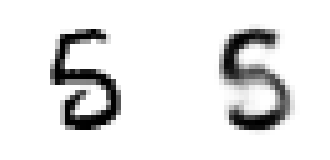

epoch:  28%|██▊       | 55/200 [12:12<32:04, 13.27s/it]


Epoch 055 train_loss: 0.0647 val_loss 0.0657
loss 0.06460936535358429


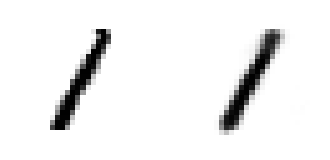

epoch:  28%|██▊       | 56/200 [12:25<31:52, 13.28s/it]


Epoch 056 train_loss: 0.0646 val_loss 0.0658
loss 0.06448735929369927


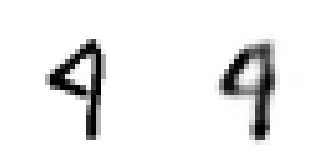

epoch:  28%|██▊       | 57/200 [12:40<32:49, 13.77s/it]


Epoch 057 train_loss: 0.0645 val_loss 0.0655
loss 0.06439138405203819


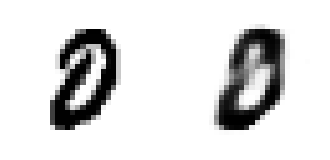

epoch:  29%|██▉       | 58/200 [12:54<32:55, 13.91s/it]


Epoch 058 train_loss: 0.0644 val_loss 0.0652
loss 0.06430383627176285


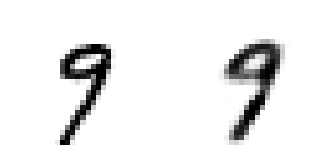

epoch:  30%|██▉       | 59/200 [13:08<32:25, 13.80s/it]


Epoch 059 train_loss: 0.0643 val_loss 0.0657
loss 0.0642071006989479


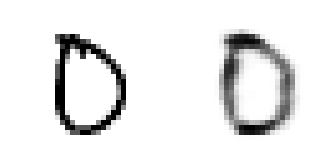

epoch:  30%|███       | 60/200 [13:21<31:46, 13.62s/it]


Epoch 060 train_loss: 0.0642 val_loss 0.0652
loss 0.06412144321680069


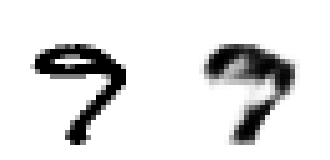

epoch:  30%|███       | 61/200 [13:34<31:23, 13.55s/it]


Epoch 061 train_loss: 0.0641 val_loss 0.0651
loss 0.06399844325065612


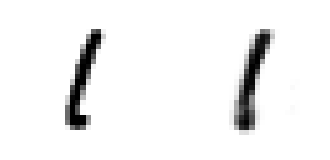

epoch:  31%|███       | 62/200 [13:48<31:07, 13.53s/it]


Epoch 062 train_loss: 0.0640 val_loss 0.0648
loss 0.06390968006134033


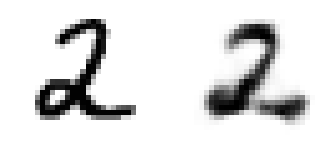

epoch:  32%|███▏      | 63/200 [14:01<30:43, 13.45s/it]


Epoch 063 train_loss: 0.0639 val_loss 0.0648
loss 0.06381172985553742


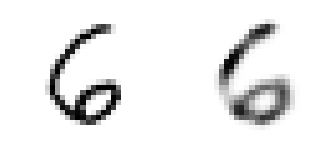

epoch:  32%|███▏      | 64/200 [14:15<30:34, 13.49s/it]


Epoch 064 train_loss: 0.0638 val_loss 0.0648
loss 0.06372952826976776


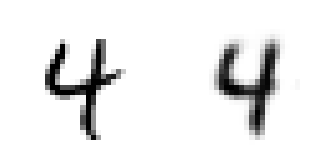

epoch:  32%|███▎      | 65/200 [14:28<30:14, 13.44s/it]


Epoch 065 train_loss: 0.0637 val_loss 0.0646
loss 0.06363271332740783


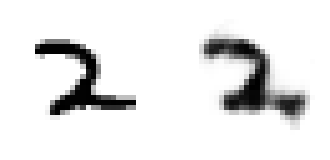

epoch:  33%|███▎      | 66/200 [14:42<30:04, 13.47s/it]


Epoch 066 train_loss: 0.0636 val_loss 0.0645
loss 0.063585910166502


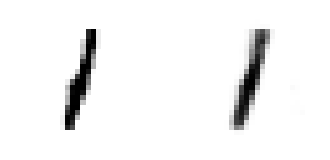

epoch:  34%|███▎      | 67/200 [14:55<29:41, 13.39s/it]


Epoch 067 train_loss: 0.0636 val_loss 0.0645
loss 0.06343158643960953


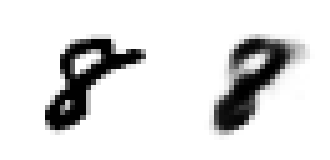

epoch:  34%|███▍      | 68/200 [15:08<29:24, 13.36s/it]


Epoch 068 train_loss: 0.0634 val_loss 0.0647
loss 0.06341538205623627


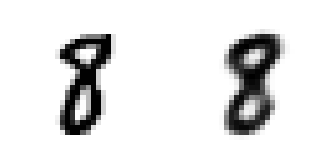

epoch:  34%|███▍      | 69/200 [15:21<29:06, 13.33s/it]


Epoch 069 train_loss: 0.0634 val_loss 0.0644
loss 0.06329273061156272


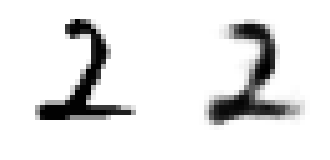

epoch:  35%|███▌      | 70/200 [15:35<28:55, 13.35s/it]


Epoch 070 train_loss: 0.0633 val_loss 0.0645
loss 0.06323608580708504


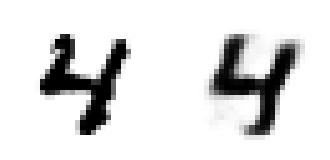

epoch:  36%|███▌      | 71/200 [15:48<28:40, 13.34s/it]


Epoch 071 train_loss: 0.0632 val_loss 0.0642
loss 0.06314184262514114


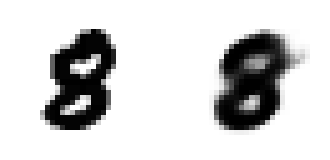

epoch:  36%|███▌      | 72/200 [16:01<28:19, 13.28s/it]


Epoch 072 train_loss: 0.0631 val_loss 0.0641
loss 0.06304305150270462


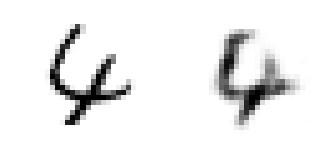

epoch:  36%|███▋      | 73/200 [16:14<28:04, 13.26s/it]


Epoch 073 train_loss: 0.0630 val_loss 0.0640
loss 0.06301614818572998


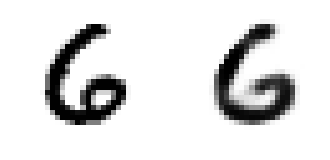

epoch:  37%|███▋      | 74/200 [16:28<27:54, 13.29s/it]


Epoch 074 train_loss: 0.0630 val_loss 0.0639
loss 0.06292689046382904


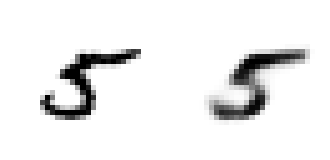

epoch:  38%|███▊      | 75/200 [16:41<27:38, 13.26s/it]


Epoch 075 train_loss: 0.0629 val_loss 0.0640
loss 0.06286203437924386


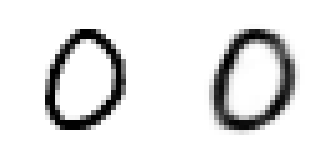

epoch:  38%|███▊      | 76/200 [16:54<27:19, 13.23s/it]


Epoch 076 train_loss: 0.0629 val_loss 0.0640
loss 0.0628040762591362


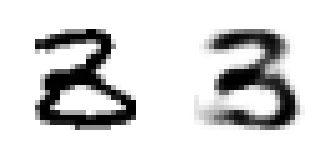

epoch:  38%|███▊      | 77/200 [17:07<27:03, 13.20s/it]


Epoch 077 train_loss: 0.0628 val_loss 0.0638
loss 0.0627252502655983


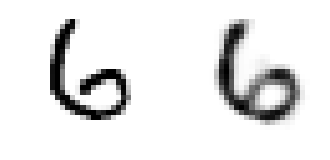

epoch:  39%|███▉      | 78/200 [17:20<26:47, 13.18s/it]


Epoch 078 train_loss: 0.0627 val_loss 0.0637
loss 0.06262355114936828


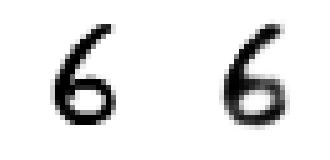

epoch:  40%|███▉      | 79/200 [17:34<26:35, 13.19s/it]


Epoch 079 train_loss: 0.0626 val_loss 0.0636
loss 0.06258092692375183


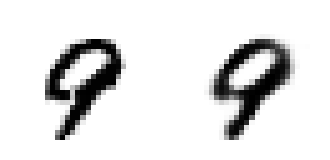

epoch:  40%|████      | 80/200 [17:47<26:24, 13.21s/it]


Epoch 080 train_loss: 0.0626 val_loss 0.0637
loss 0.06252776233434677


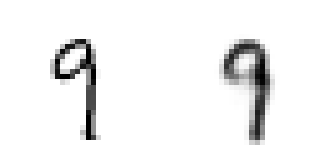

epoch:  40%|████      | 81/200 [18:00<26:09, 13.19s/it]


Epoch 081 train_loss: 0.0625 val_loss 0.0636
loss 0.06244828535079956


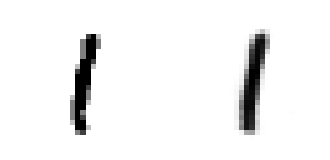

epoch:  41%|████      | 82/200 [18:13<25:51, 13.15s/it]


Epoch 082 train_loss: 0.0624 val_loss 0.0633
loss 0.06239329893946648


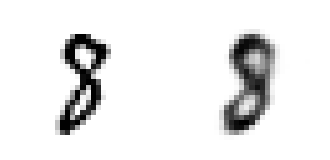

epoch:  42%|████▏     | 83/200 [18:26<25:46, 13.22s/it]


Epoch 083 train_loss: 0.0624 val_loss 0.0635
loss 0.06233322709798813


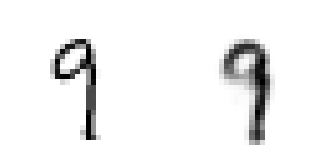

epoch:  42%|████▏     | 84/200 [18:40<25:32, 13.21s/it]


Epoch 084 train_loss: 0.0623 val_loss 0.0634
loss 0.062264368937015535


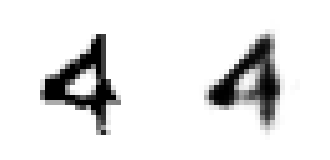

epoch:  42%|████▎     | 85/200 [18:53<25:19, 13.22s/it]


Epoch 085 train_loss: 0.0623 val_loss 0.0633
loss 0.062230233800411226


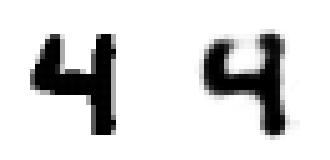

epoch:  43%|████▎     | 86/200 [19:06<25:03, 13.18s/it]


Epoch 086 train_loss: 0.0622 val_loss 0.0633
loss 0.06217769511461258


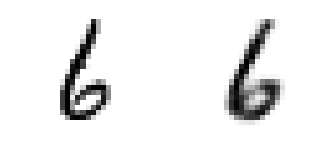

epoch:  44%|████▎     | 87/200 [19:19<25:00, 13.27s/it]


Epoch 087 train_loss: 0.0622 val_loss 0.0631
loss 0.062135862830877304


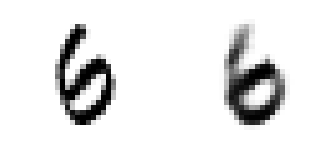

epoch:  44%|████▍     | 88/200 [19:32<24:40, 13.21s/it]


Epoch 088 train_loss: 0.0621 val_loss 0.0633
loss 0.06212829409599304


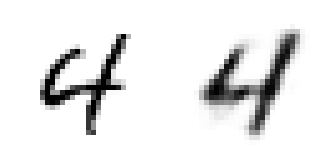

epoch:  44%|████▍     | 89/200 [19:46<24:31, 13.25s/it]


Epoch 089 train_loss: 0.0621 val_loss 0.0633
loss 0.062011063313484195


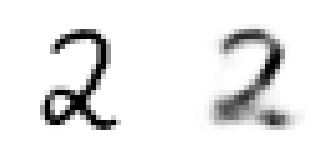

epoch:  45%|████▌     | 90/200 [19:59<24:20, 13.28s/it]


Epoch 090 train_loss: 0.0620 val_loss 0.0629
loss 0.06194997287988663


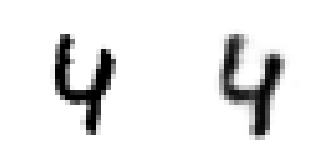

epoch:  46%|████▌     | 91/200 [20:12<24:06, 13.27s/it]


Epoch 091 train_loss: 0.0619 val_loss 0.0630
loss 0.06191125992774963


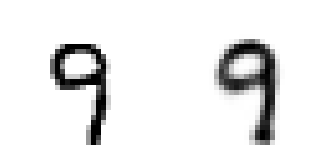

epoch:  46%|████▌     | 92/200 [20:26<23:53, 13.28s/it]


Epoch 092 train_loss: 0.0619 val_loss 0.0629
loss 0.06189104382276535


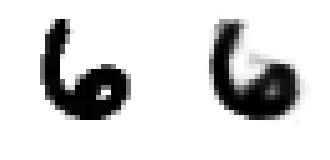

epoch:  46%|████▋     | 93/200 [20:39<23:40, 13.27s/it]


Epoch 093 train_loss: 0.0619 val_loss 0.0630
loss 0.06181502904057503


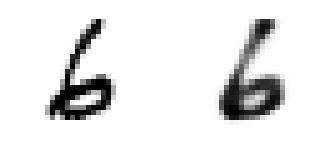

epoch:  47%|████▋     | 94/200 [20:54<24:22, 13.80s/it]


Epoch 094 train_loss: 0.0618 val_loss 0.0630
loss 0.061820798194408416


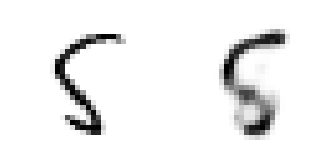

epoch:  48%|████▊     | 95/200 [21:07<23:57, 13.69s/it]


Epoch 095 train_loss: 0.0618 val_loss 0.0628
loss 0.06177384130239487


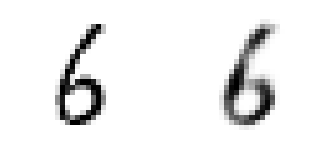

epoch:  48%|████▊     | 96/200 [21:21<23:32, 13.58s/it]


Epoch 096 train_loss: 0.0618 val_loss 0.0628
loss 0.06173391764163971


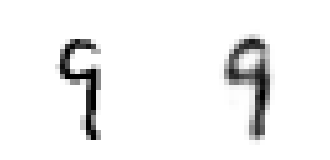

epoch:  48%|████▊     | 97/200 [21:34<23:19, 13.59s/it]


Epoch 097 train_loss: 0.0617 val_loss 0.0627
loss 0.06169175144910812


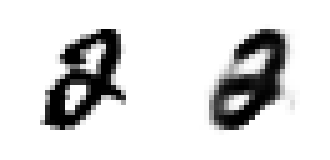

epoch:  49%|████▉     | 98/200 [21:48<22:56, 13.49s/it]


Epoch 098 train_loss: 0.0617 val_loss 0.0628
loss 0.061634920033216474


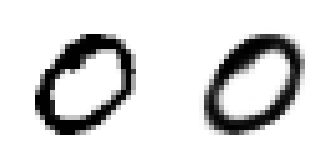

epoch:  50%|████▉     | 99/200 [22:01<22:33, 13.40s/it]


Epoch 099 train_loss: 0.0616 val_loss 0.0628
loss 0.06163627734422684


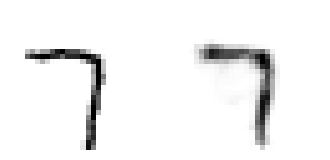

epoch:  50%|█████     | 100/200 [22:14<22:14, 13.34s/it]


Epoch 100 train_loss: 0.0616 val_loss 0.0628
loss 0.06154180293798447


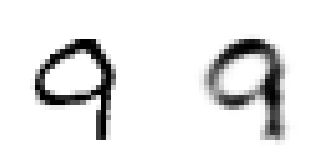

epoch:  50%|█████     | 101/200 [22:27<21:59, 13.33s/it]


Epoch 101 train_loss: 0.0615 val_loss 0.0627
loss 0.061521282143592836


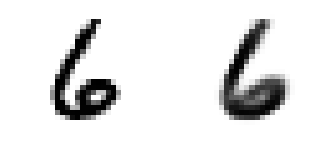

epoch:  51%|█████     | 102/200 [22:41<21:42, 13.30s/it]


Epoch 102 train_loss: 0.0615 val_loss 0.0627
loss 0.06149466228485107


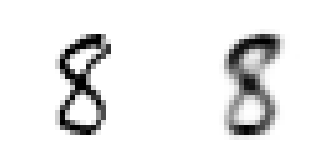

epoch:  52%|█████▏    | 103/200 [22:54<21:34, 13.35s/it]


Epoch 103 train_loss: 0.0615 val_loss 0.0626
loss 0.061470233334302904


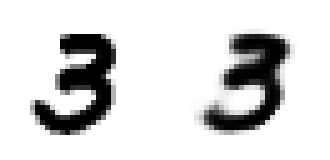

epoch:  52%|█████▏    | 104/200 [23:07<21:20, 13.34s/it]


Epoch 104 train_loss: 0.0615 val_loss 0.0626
loss 0.0613920302772522


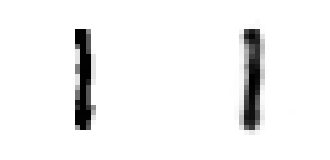

epoch:  52%|█████▎    | 105/200 [23:21<21:07, 13.34s/it]


Epoch 105 train_loss: 0.0614 val_loss 0.0625
loss 0.06140190508365631


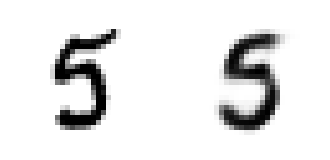

epoch:  53%|█████▎    | 106/200 [23:34<20:51, 13.32s/it]


Epoch 106 train_loss: 0.0614 val_loss 0.0627
loss 0.06135704959750175


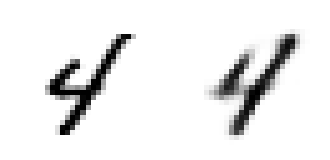

epoch:  54%|█████▎    | 107/200 [23:47<20:36, 13.29s/it]


Epoch 107 train_loss: 0.0614 val_loss 0.0625
loss 0.06134017085909844


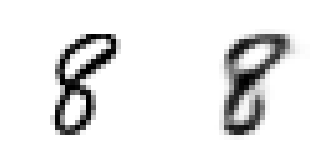

epoch:  54%|█████▍    | 108/200 [24:00<20:22, 13.28s/it]


Epoch 108 train_loss: 0.0613 val_loss 0.0623
loss 0.06128538455605507


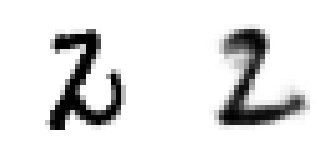

epoch:  55%|█████▍    | 109/200 [24:14<20:11, 13.31s/it]


Epoch 109 train_loss: 0.0613 val_loss 0.0624
loss 0.06131097194910049


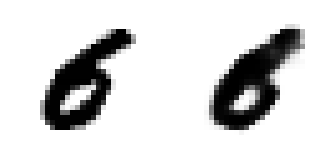

epoch:  55%|█████▌    | 110/200 [24:27<20:05, 13.39s/it]


Epoch 110 train_loss: 0.0613 val_loss 0.0624
loss 0.061204269629716875


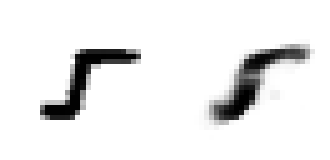

epoch:  56%|█████▌    | 111/200 [24:41<19:49, 13.36s/it]


Epoch 111 train_loss: 0.0612 val_loss 0.0625
loss 0.06118018376350403


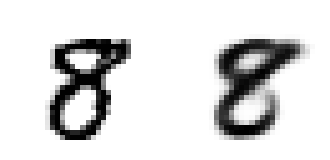

epoch:  56%|█████▌    | 112/200 [24:54<19:39, 13.41s/it]


Epoch 112 train_loss: 0.0612 val_loss 0.0625
loss 0.06118357059240341


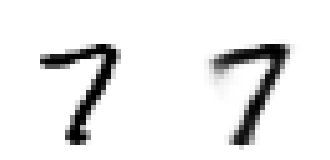

epoch:  56%|█████▋    | 113/200 [25:07<19:21, 13.36s/it]


Epoch 113 train_loss: 0.0612 val_loss 0.0623
loss 0.06118243543624878


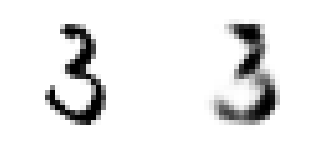

epoch:  57%|█████▋    | 114/200 [25:21<19:11, 13.39s/it]


Epoch 114 train_loss: 0.0612 val_loss 0.0623
loss 0.061085997844934466


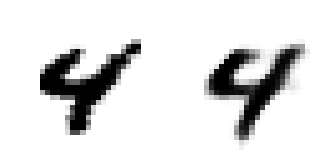

epoch:  57%|█████▊    | 115/200 [25:34<18:58, 13.39s/it]


Epoch 115 train_loss: 0.0611 val_loss 0.0621
loss 0.061092476876974104


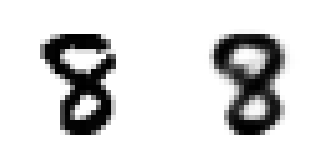

epoch:  58%|█████▊    | 116/200 [25:48<18:49, 13.45s/it]


Epoch 116 train_loss: 0.0611 val_loss 0.0623
loss 0.061015305948257444


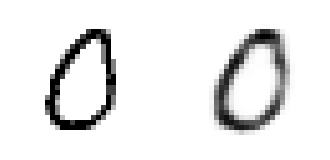

epoch:  58%|█████▊    | 117/200 [26:01<18:38, 13.48s/it]


Epoch 117 train_loss: 0.0610 val_loss 0.0622
loss 0.061016685067415234


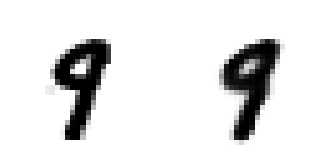

epoch:  59%|█████▉    | 118/200 [26:15<18:25, 13.48s/it]


Epoch 118 train_loss: 0.0610 val_loss 0.0622
loss 0.060996028847694395


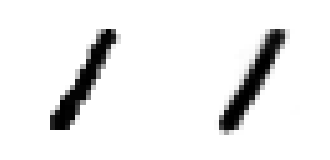

epoch:  60%|█████▉    | 119/200 [26:28<18:10, 13.46s/it]


Epoch 119 train_loss: 0.0610 val_loss 0.0621
loss 0.060936706465482715


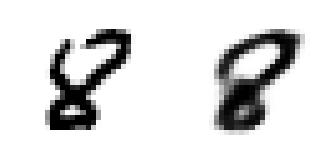

epoch:  60%|██████    | 120/200 [26:42<17:54, 13.43s/it]


Epoch 120 train_loss: 0.0609 val_loss 0.0621
loss 0.0608747803413868


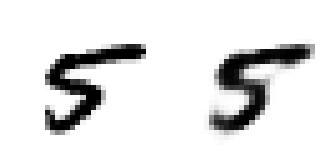

epoch:  60%|██████    | 121/200 [26:55<17:41, 13.43s/it]


Epoch 121 train_loss: 0.0609 val_loss 0.0620
loss 0.06093115512371063


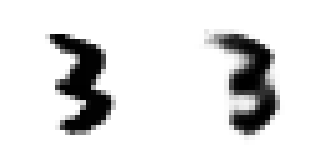

epoch:  61%|██████    | 122/200 [27:08<17:26, 13.42s/it]


Epoch 122 train_loss: 0.0609 val_loss 0.0620
loss 0.0609134778881073


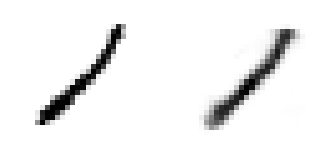

epoch:  62%|██████▏   | 123/200 [27:22<17:16, 13.46s/it]


Epoch 123 train_loss: 0.0609 val_loss 0.0619
loss 0.06084477899312973


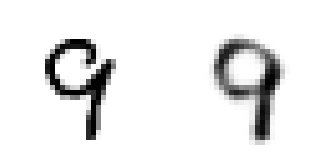

epoch:  62%|██████▏   | 124/200 [27:35<17:00, 13.42s/it]


Epoch 124 train_loss: 0.0608 val_loss 0.0624
loss 0.06081415518283844


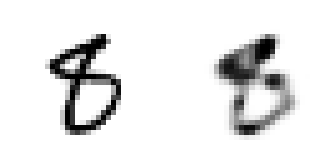

epoch:  62%|██████▎   | 125/200 [27:49<16:47, 13.44s/it]


Epoch 125 train_loss: 0.0608 val_loss 0.0619
loss 0.06081053161859512


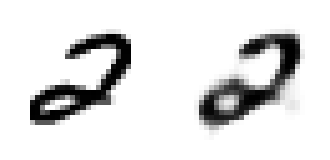

epoch:  63%|██████▎   | 126/200 [28:02<16:33, 13.42s/it]


Epoch 126 train_loss: 0.0608 val_loss 0.0618
loss 0.0608159914791584


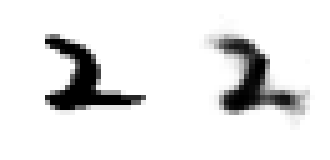

epoch:  64%|██████▎   | 127/200 [28:15<16:15, 13.36s/it]


Epoch 127 train_loss: 0.0608 val_loss 0.0620
loss 0.0607102314722538


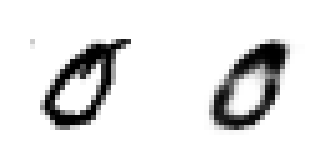

epoch:  64%|██████▍   | 128/200 [28:29<16:03, 13.38s/it]


Epoch 128 train_loss: 0.0607 val_loss 0.0619
loss 0.06070977254509926


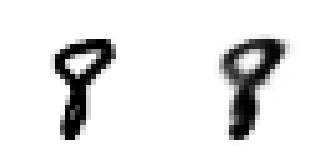

epoch:  64%|██████▍   | 129/200 [28:42<15:45, 13.31s/it]


Epoch 129 train_loss: 0.0607 val_loss 0.0617
loss 0.06068344596028328


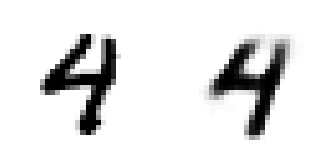

epoch:  65%|██████▌   | 130/200 [28:57<15:59, 13.71s/it]


Epoch 130 train_loss: 0.0607 val_loss 0.0620
loss 0.060698537817001345


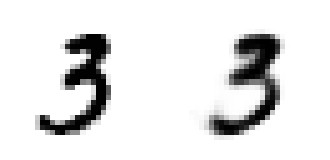

epoch:  66%|██████▌   | 131/200 [29:10<15:33, 13.53s/it]


Epoch 131 train_loss: 0.0607 val_loss 0.0619
loss 0.06063473965525627


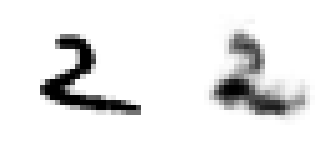

epoch:  66%|██████▌   | 132/200 [29:23<15:17, 13.49s/it]


Epoch 132 train_loss: 0.0606 val_loss 0.0620
loss 0.06067275090813637


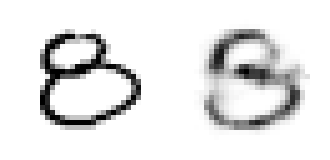

epoch:  66%|██████▋   | 133/200 [29:36<14:58, 13.41s/it]


Epoch 133 train_loss: 0.0607 val_loss 0.0617
loss 0.06061125427007675


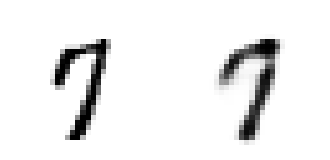

epoch:  67%|██████▋   | 134/200 [29:50<14:43, 13.38s/it]


Epoch 134 train_loss: 0.0606 val_loss 0.0619
loss 0.06056236366271973


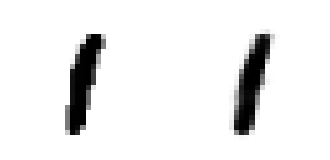

epoch:  68%|██████▊   | 135/200 [30:03<14:29, 13.37s/it]


Epoch 135 train_loss: 0.0606 val_loss 0.0618
loss 0.060578662588596344


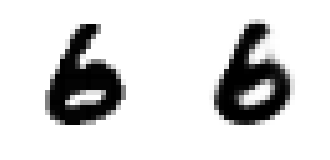

epoch:  68%|██████▊   | 136/200 [30:16<14:15, 13.37s/it]


Epoch 136 train_loss: 0.0606 val_loss 0.0617
loss 0.06054371161937713


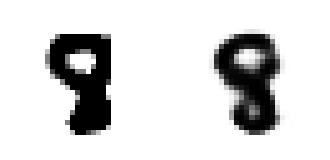

epoch:  68%|██████▊   | 137/200 [30:29<13:56, 13.27s/it]


Epoch 137 train_loss: 0.0605 val_loss 0.0616
loss 0.060487045207023624


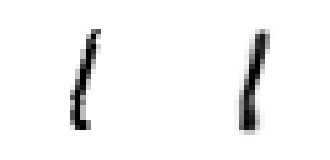

epoch:  69%|██████▉   | 138/200 [30:42<13:36, 13.17s/it]


Epoch 138 train_loss: 0.0605 val_loss 0.0621
loss 0.06050628440618515


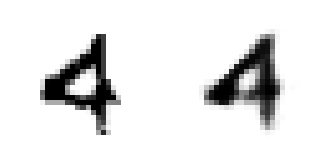

epoch:  70%|██████▉   | 139/200 [30:56<13:23, 13.18s/it]


Epoch 139 train_loss: 0.0605 val_loss 0.0620
loss 0.060475185265541076


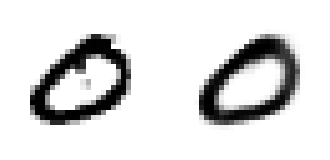

epoch:  70%|███████   | 140/200 [31:09<13:10, 13.18s/it]


Epoch 140 train_loss: 0.0605 val_loss 0.0618
loss 0.06047666326165199


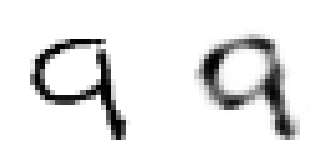

epoch:  70%|███████   | 141/200 [31:22<12:56, 13.16s/it]


Epoch 141 train_loss: 0.0605 val_loss 0.0616
loss 0.06040101886510849


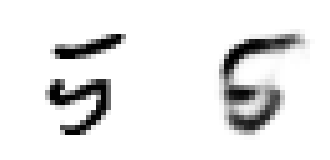

epoch:  71%|███████   | 142/200 [31:35<12:49, 13.27s/it]


Epoch 142 train_loss: 0.0604 val_loss 0.0615
loss 0.060403562355041504


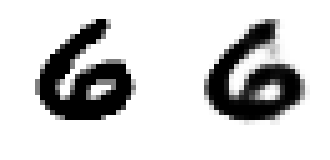

epoch:  72%|███████▏  | 143/200 [31:49<12:34, 13.25s/it]


Epoch 143 train_loss: 0.0604 val_loss 0.0617
loss 0.0603528392457962


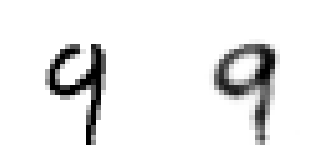

epoch:  72%|███████▏  | 144/200 [32:02<12:18, 13.19s/it]


Epoch 144 train_loss: 0.0604 val_loss 0.0618
loss 0.060399797892570495


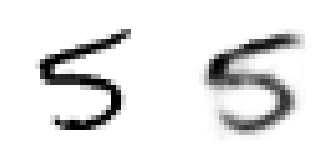

epoch:  72%|███████▎  | 145/200 [32:15<12:02, 13.14s/it]


Epoch 145 train_loss: 0.0604 val_loss 0.0616
loss 0.060384474835395816


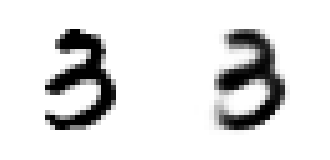

epoch:  73%|███████▎  | 146/200 [32:28<11:49, 13.14s/it]


Epoch 146 train_loss: 0.0604 val_loss 0.0616
loss 0.06029229365229607


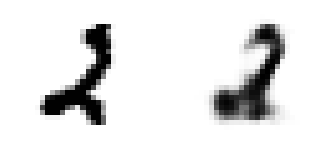

epoch:  74%|███████▎  | 147/200 [32:41<11:35, 13.13s/it]


Epoch 147 train_loss: 0.0603 val_loss 0.0615
loss 0.060308670139312744


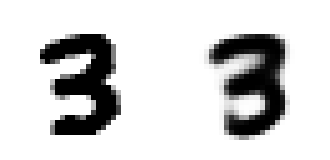

epoch:  74%|███████▍  | 148/200 [32:54<11:14, 12.97s/it]


Epoch 148 train_loss: 0.0603 val_loss 0.0617
loss 0.060262217522859575


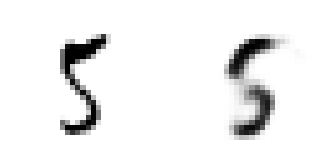

epoch:  74%|███████▍  | 149/200 [33:07<11:08, 13.11s/it]


Epoch 149 train_loss: 0.0603 val_loss 0.0615
loss 0.060231355023384094


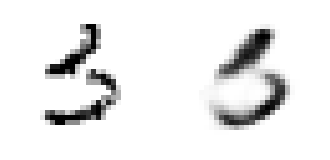

epoch:  75%|███████▌  | 150/200 [33:21<11:04, 13.30s/it]


Epoch 150 train_loss: 0.0602 val_loss 0.0614
loss 0.060219857255220416


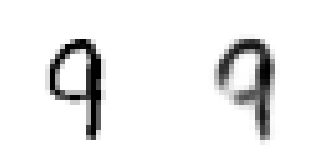

epoch:  76%|███████▌  | 151/200 [33:34<10:50, 13.27s/it]


Epoch 151 train_loss: 0.0602 val_loss 0.0614
loss 0.06023899631977081


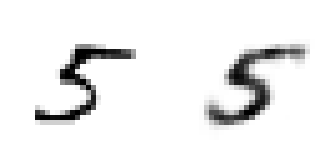

epoch:  76%|███████▌  | 152/200 [33:47<10:34, 13.23s/it]


Epoch 152 train_loss: 0.0602 val_loss 0.0614
loss 0.06022336591243744


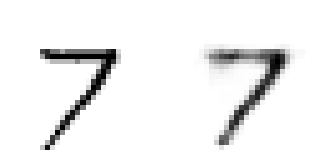

epoch:  76%|███████▋  | 153/200 [34:00<10:22, 13.24s/it]


Epoch 153 train_loss: 0.0602 val_loss 0.0616
loss 0.06021994687199592


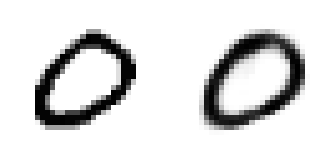

epoch:  77%|███████▋  | 154/200 [34:13<10:06, 13.18s/it]


Epoch 154 train_loss: 0.0602 val_loss 0.0616
loss 0.060133418028354646


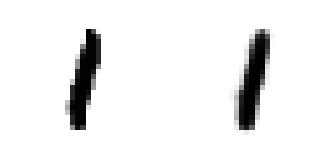

epoch:  78%|███████▊  | 155/200 [34:26<09:51, 13.14s/it]


Epoch 155 train_loss: 0.0601 val_loss 0.0613
loss 0.06015104437828064


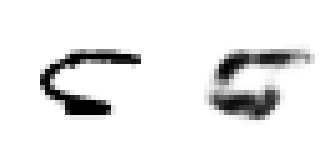

epoch:  78%|███████▊  | 156/200 [34:39<09:35, 13.08s/it]


Epoch 156 train_loss: 0.0602 val_loss 0.0613
loss 0.06013857645988464


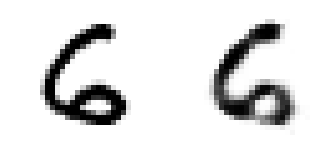

epoch:  78%|███████▊  | 157/200 [34:52<09:20, 13.03s/it]


Epoch 157 train_loss: 0.0601 val_loss 0.0613
loss 0.060097080632448195


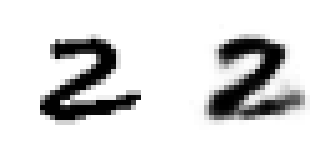

epoch:  79%|███████▉  | 158/200 [35:05<09:09, 13.08s/it]


Epoch 158 train_loss: 0.0601 val_loss 0.0612
loss 0.0601090316927433


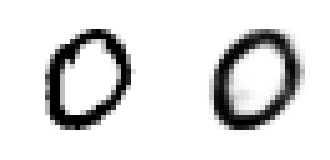

epoch:  80%|███████▉  | 159/200 [35:19<08:56, 13.09s/it]


Epoch 159 train_loss: 0.0601 val_loss 0.0615
loss 0.060075124685764314


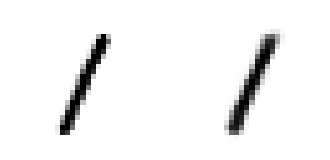

epoch:  80%|████████  | 160/200 [35:32<08:45, 13.13s/it]


Epoch 160 train_loss: 0.0601 val_loss 0.0613
loss 0.06004613346338272


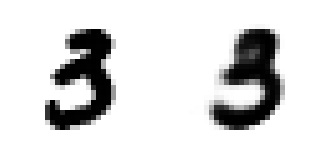

epoch:  80%|████████  | 161/200 [35:45<08:30, 13.10s/it]


Epoch 161 train_loss: 0.0600 val_loss 0.0611
loss 0.06004745141386986


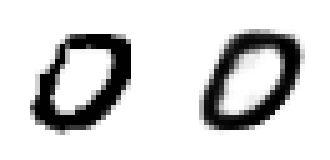

epoch:  81%|████████  | 162/200 [35:58<08:15, 13.03s/it]


Epoch 162 train_loss: 0.0600 val_loss 0.0616
loss 0.0600211309170723


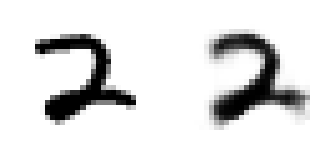

epoch:  82%|████████▏ | 163/200 [36:11<08:00, 13.00s/it]


Epoch 163 train_loss: 0.0600 val_loss 0.0617
loss 0.05996408966779709


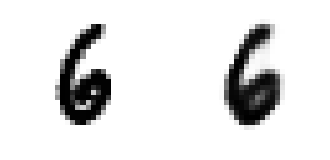

epoch:  82%|████████▏ | 164/200 [36:24<07:51, 13.09s/it]


Epoch 164 train_loss: 0.0600 val_loss 0.0611
loss 0.05998532058000564


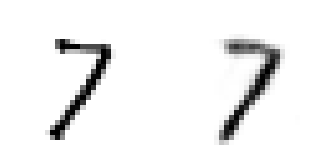

epoch:  82%|████████▎ | 165/200 [36:37<07:37, 13.07s/it]


Epoch 165 train_loss: 0.0600 val_loss 0.0612
loss 0.05997862548232079


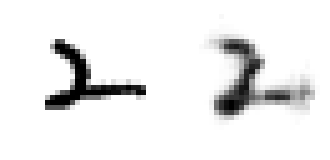

epoch:  83%|████████▎ | 166/200 [36:50<07:23, 13.04s/it]


Epoch 166 train_loss: 0.0600 val_loss 0.0612
loss 0.059944159696102145


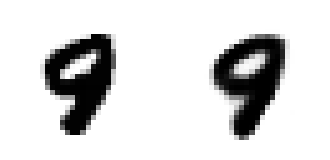

epoch:  84%|████████▎ | 167/200 [37:03<07:11, 13.09s/it]


Epoch 167 train_loss: 0.0599 val_loss 0.0613
loss 0.059916991820335386


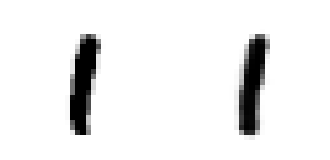

epoch:  84%|████████▍ | 168/200 [37:17<07:09, 13.42s/it]


Epoch 168 train_loss: 0.0599 val_loss 0.0612
loss 0.059906847410202024


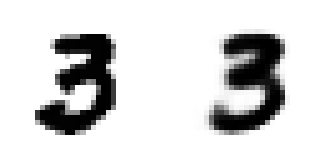

epoch:  84%|████████▍ | 169/200 [37:30<06:52, 13.31s/it]


Epoch 169 train_loss: 0.0599 val_loss 0.0611
loss 0.0598751728951931


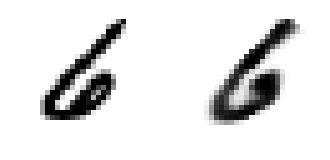

epoch:  85%|████████▌ | 170/200 [37:43<06:36, 13.20s/it]


Epoch 170 train_loss: 0.0599 val_loss 0.0613
loss 0.059893740941286085


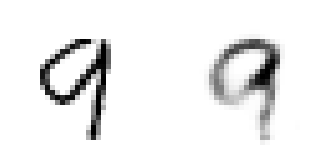

epoch:  86%|████████▌ | 171/200 [37:56<06:22, 13.19s/it]


Epoch 171 train_loss: 0.0599 val_loss 0.0611
loss 0.059859295235872266


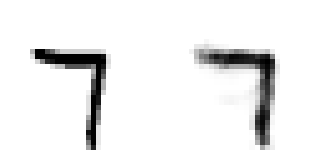

epoch:  86%|████████▌ | 172/200 [38:10<06:08, 13.15s/it]


Epoch 172 train_loss: 0.0599 val_loss 0.0613
loss 0.059845330475568774


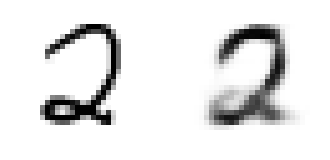

epoch:  86%|████████▋ | 173/200 [38:23<05:54, 13.14s/it]


Epoch 173 train_loss: 0.0598 val_loss 0.0611
loss 0.0598215483379364


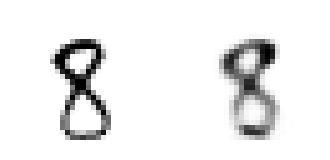

epoch:  87%|████████▋ | 174/200 [38:36<05:40, 13.10s/it]


Epoch 174 train_loss: 0.0598 val_loss 0.0611
loss 0.059798739241361615


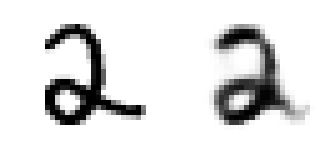

epoch:  88%|████████▊ | 175/200 [38:49<05:26, 13.07s/it]


Epoch 175 train_loss: 0.0598 val_loss 0.0612
loss 0.05979351680755615


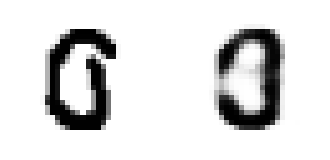

epoch:  88%|████████▊ | 176/200 [39:02<05:13, 13.07s/it]


Epoch 176 train_loss: 0.0598 val_loss 0.0608
loss 0.05978946647763252


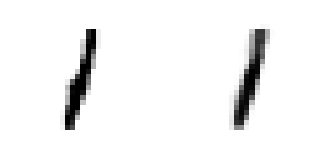

epoch:  88%|████████▊ | 177/200 [39:15<05:04, 13.24s/it]


Epoch 177 train_loss: 0.0598 val_loss 0.0609
loss 0.05977507050037384


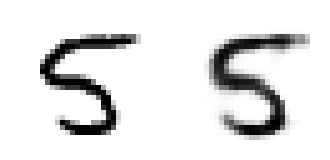

epoch:  89%|████████▉ | 178/200 [39:28<04:50, 13.19s/it]


Epoch 178 train_loss: 0.0598 val_loss 0.0609
loss 0.05973655400514603


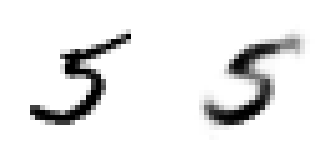

epoch:  90%|████████▉ | 179/200 [39:42<04:37, 13.19s/it]


Epoch 179 train_loss: 0.0597 val_loss 0.0610
loss 0.059742637457847594


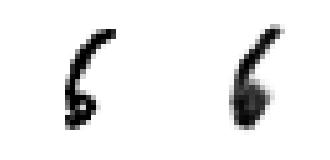

epoch:  90%|█████████ | 180/200 [39:55<04:22, 13.11s/it]


Epoch 180 train_loss: 0.0597 val_loss 0.0609
loss 0.05976343720436096


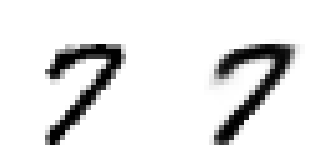

epoch:  90%|█████████ | 181/200 [40:08<04:08, 13.09s/it]


Epoch 181 train_loss: 0.0598 val_loss 0.0611
loss 0.05968190435886383


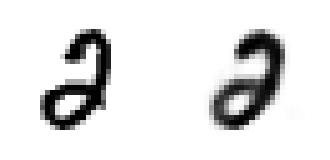

epoch:  91%|█████████ | 182/200 [40:20<03:53, 12.98s/it]


Epoch 182 train_loss: 0.0597 val_loss 0.0612
loss 0.059673762022256854


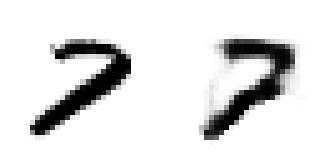

epoch:  92%|█████████▏| 183/200 [40:33<03:39, 12.94s/it]


Epoch 183 train_loss: 0.0597 val_loss 0.0609
loss 0.05970905323624611


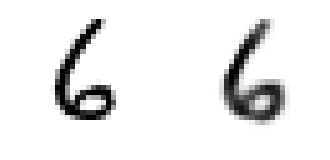

epoch:  92%|█████████▏| 184/200 [40:46<03:25, 12.86s/it]


Epoch 184 train_loss: 0.0597 val_loss 0.0610
loss 0.0596738330245018


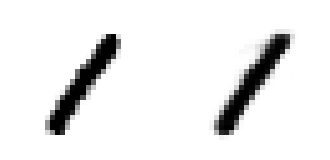

epoch:  92%|█████████▎| 185/200 [40:59<03:12, 12.85s/it]


Epoch 185 train_loss: 0.0597 val_loss 0.0606
loss 0.05968310894727707


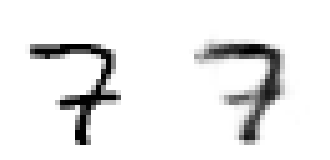

epoch:  93%|█████████▎| 186/200 [41:11<02:59, 12.84s/it]


Epoch 186 train_loss: 0.0597 val_loss 0.0609
loss 0.059649341686964036


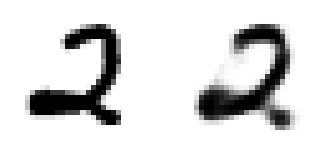

epoch:  94%|█████████▎| 187/200 [41:24<02:46, 12.79s/it]


Epoch 187 train_loss: 0.0596 val_loss 0.0609
loss 0.059595475616455076


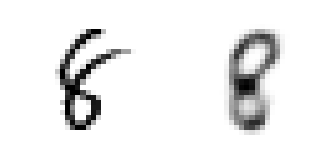

epoch:  94%|█████████▍| 188/200 [41:37<02:33, 12.82s/it]


Epoch 188 train_loss: 0.0596 val_loss 0.0607
loss 0.059639229454994204


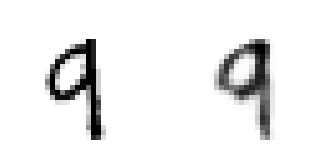

epoch:  94%|█████████▍| 189/200 [41:50<02:20, 12.81s/it]


Epoch 189 train_loss: 0.0596 val_loss 0.0607
loss 0.05959407917022705


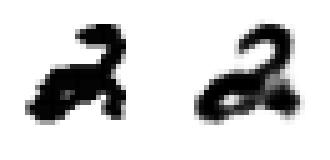

epoch:  95%|█████████▌| 190/200 [42:03<02:09, 12.94s/it]


Epoch 190 train_loss: 0.0596 val_loss 0.0610
loss 0.05955749555230141


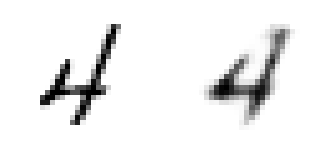

epoch:  96%|█████████▌| 191/200 [42:16<01:57, 13.02s/it]


Epoch 191 train_loss: 0.0596 val_loss 0.0609
loss 0.059549601573944094


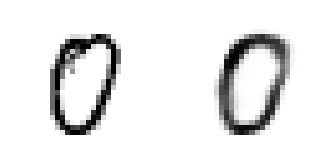

epoch:  96%|█████████▌| 192/200 [42:29<01:43, 12.97s/it]


Epoch 192 train_loss: 0.0595 val_loss 0.0608
loss 0.05954583610534668


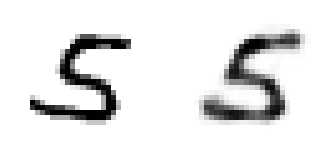

epoch:  96%|█████████▋| 193/200 [42:42<01:30, 12.96s/it]


Epoch 193 train_loss: 0.0595 val_loss 0.0609
loss 0.05955903562426567


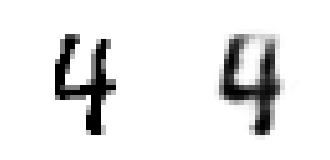

epoch:  97%|█████████▋| 194/200 [42:55<01:17, 12.90s/it]


Epoch 194 train_loss: 0.0596 val_loss 0.0609
loss 0.059474918336868285


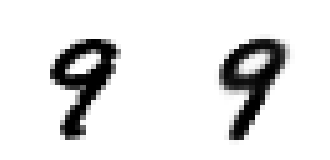

epoch:  98%|█████████▊| 195/200 [43:08<01:04, 12.98s/it]


Epoch 195 train_loss: 0.0595 val_loss 0.0608
loss 0.059511774747371675


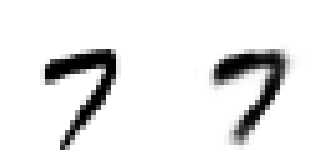

epoch:  98%|█████████▊| 196/200 [43:21<00:51, 12.95s/it]


Epoch 196 train_loss: 0.0595 val_loss 0.0608
loss 0.05951989945292473


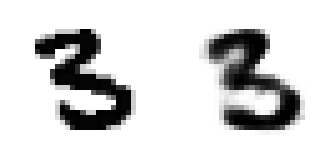

epoch:  98%|█████████▊| 197/200 [43:34<00:38, 12.92s/it]


Epoch 197 train_loss: 0.0595 val_loss 0.0607
loss 0.05947987812638283


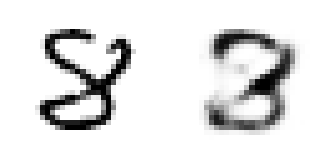

epoch:  99%|█████████▉| 198/200 [43:47<00:25, 12.89s/it]


Epoch 198 train_loss: 0.0595 val_loss 0.0606
loss 0.05944109814167023


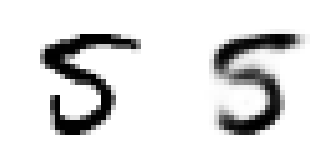

epoch: 100%|█████████▉| 199/200 [44:00<00:12, 12.97s/it]


Epoch 199 train_loss: 0.0594 val_loss 0.0606
loss 0.05946935974121094


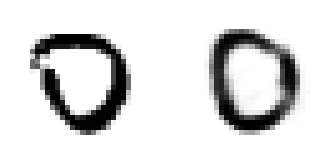

epoch: 100%|██████████| 200/200 [44:13<00:00, 13.27s/it]


Epoch 200 train_loss: 0.0595 val_loss 0.0610


In [10]:
history = train(train_dataset, val_dataset, model=model, epochs=200, batch_size=128, is_cvae=False)

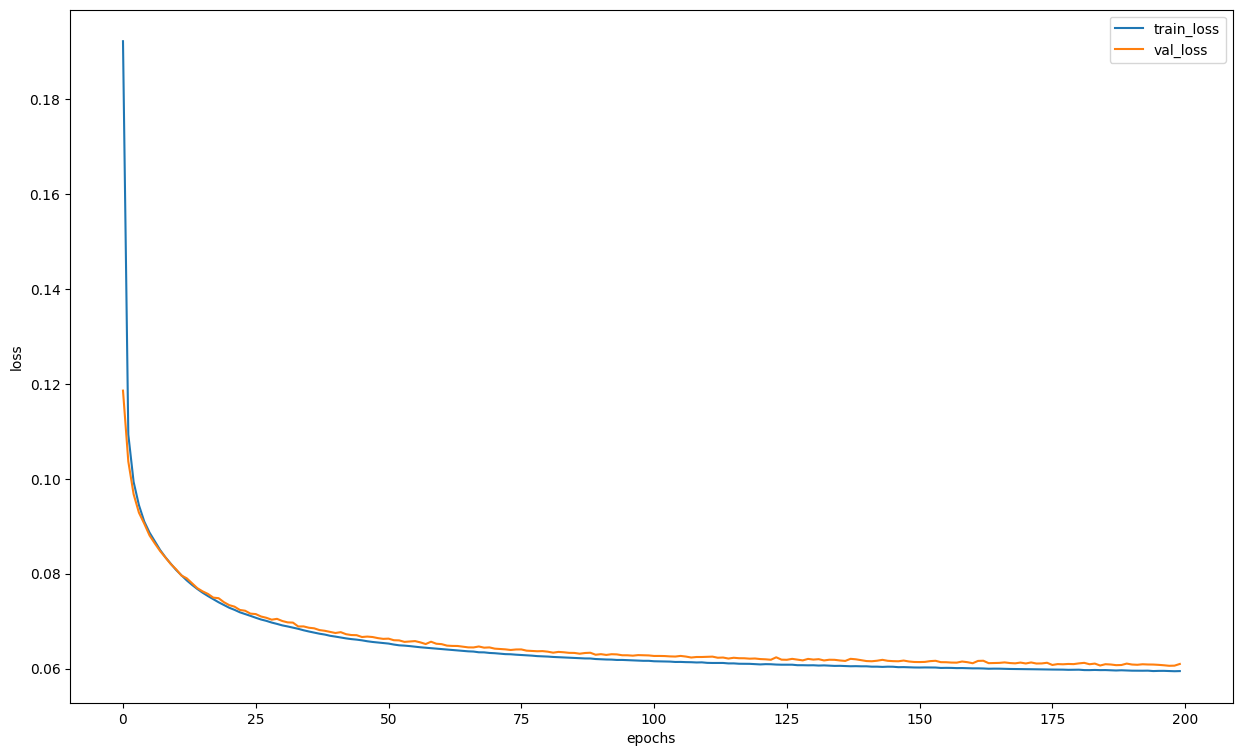

In [11]:
plot_loss(history)

# Sampling

Now we can try to get not the random pictures, but the numbers we want to generate. Let's say numbers from 0 to 9.

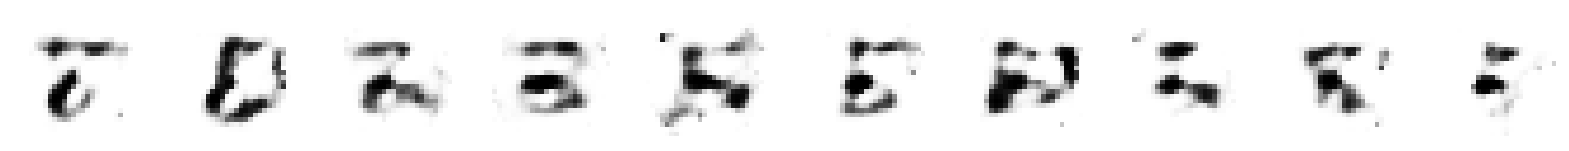

In [12]:
with torch.set_grad_enabled(False):
    number_for_generation=[0,1,2,3,4,5,6,7,8,9]
    inputs = torch.FloatTensor(np.random.randn(10*28*28).reshape(-1,28,28))
    inputs = inputs.to(DEVICE)
    label = one_hot(number_for_generation,9).to(DEVICE)
    outputs = model(inputs,label)
    plot_gallery(outputs.cpu(),28,28,1,10)

# Exploring the latent space using t-SNE

t-Distributed Stochastic Neighbor Embedding (t-SNE) is a technique for dimensionality reduction that is particularly well suited for the visualization of high-dimensional datasets. Let's use it and plot the results.

In [13]:
def get_latent_data(net, count=1000, is_cvae=False):
    latent_vectors = []
    latent_labels = []
    img_inputs = []
    rounds = count/100
    i=0
    with torch.set_grad_enabled(False):
        dataset_loader = DataLoader(dataset, batch_size=100, shuffle=True)
        for inputs,labels in dataset_loader:
            inputs = inputs.to(DEVICE)
            labels_one_hot = one_hot(labels,9).to(DEVICE)
            if is_cvae:
                outputs, mu, logvar = net(inputs,labels_one_hot)
            else:
                outputs = net(inputs,labels_one_hot)
            outputs = outputs.cpu()
            if i==0:
              latent_vectors = outputs
              latent_labels = labels
              img_inputs = inputs
            else:
              latent_vectors = torch.cat((latent_vectors,outputs),0)
              latent_labels = torch.cat((latent_labels,labels),0)
              img_inputs = torch.cat((img_inputs,inputs),0)
            if i>rounds:
              break
            i+=1
    return img_inputs, latent_vectors, latent_labels

def plot_tsne(net, mode, count, is_cvae=False):
    img_inputs,latent_vectors,latent_labels = get_latent_data(net=net, count=count, is_cvae=is_cvae)
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.set_title('t-SNE')
    coords = TSNE(n_components=2,random_state=42).fit_transform(latent_vectors)
    if mode == 'imgs':
        for image, (x, y) in zip(img_inputs.cpu(), coords):
            im = OffsetImage(image.reshape(28, 28), zoom=1, cmap='gray')
            ab = AnnotationBbox(im, (x, y), xycoords='data', frameon=False)
            ax.add_artist(ab)
        ax.update_datalim(coords)
        ax.autoscale()
    elif mode == 'dots':
        classes = latent_labels
        plt.scatter(coords[:, 0], coords[:, 1], c=classes)
        plt.colorbar()
        for i in range(10):
            class_center = np.mean(coords[classes == i], axis=0)
            text = TextArea('{}'.format(i))
            ab = AnnotationBbox(text, class_center, xycoords='data', frameon=True)
            ax.add_artist(ab)
    plt.show()

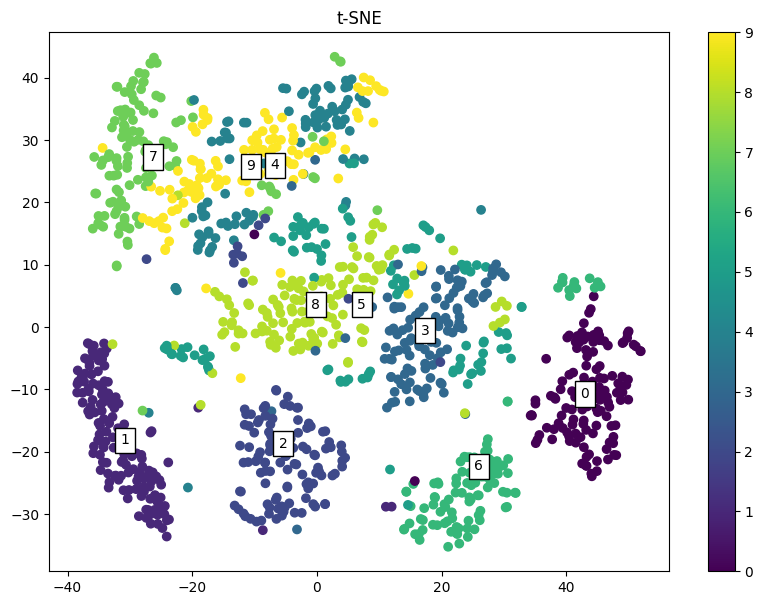

In [14]:
plot_tsne(net=model, mode='dots', count=1000)

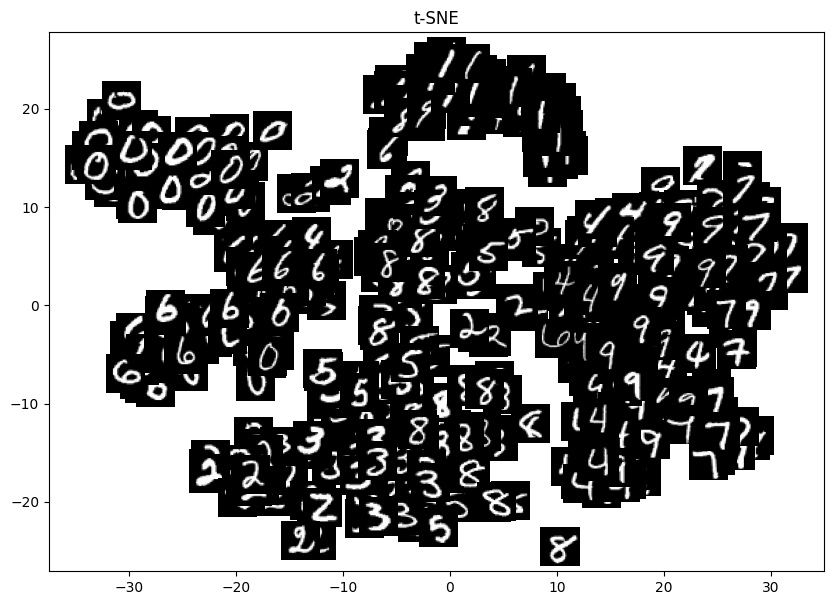

In [15]:
plot_tsne(net=model, mode='imgs', count=300)

# Conclusion

Optimizing both **reconstruction** loss and **KL divergence** loss together results in the generation of a latent space which maintains the similarity of nearby encodings on the local scale via clustering, yet globally, is very densely packed near the latent space origin (compare the axes with the original).

Cool pic:

![https://media.giphy.com/media/lqq0em9cuivVNWFwSX/giphy.gif](https://media.giphy.com/media/lqq0em9cuivVNWFwSX/giphy.gif)